# How Does Informed Trading Strategies Affect How Much Money You Can Make in the Stock Market? 

## Comparison of Several Stocks and Several Time Series models

In this notebook, we look at how Time Series models such as Simple Exponential Smoothing (SES), ARIMA, ARIMAX or even just implementing a Moving Average (MA), will influence trading decisions (BUY, SELL or HOLD). Subsequently,  we will evaluate how such ML-informed decisions can affect profitability from 8 different stocks over a 3-month period in 2021.

The process explained below includes,   
- Creation of several functions that can be called to do the repetitive analysis/predictions for the 8 stocks  
- use several combinations of p,d,q parameters for ARIMA or ARIMAX models that have been tested in previous notebook   
- random trading approach was NOT used in this notebook and was assumed to generate losses consistently  
- evaluate each of the Time Series Models on each of the stocks and create a dataframe with profits generated
- how much profit can be made with trading decisions informed by Time Series model predictions and Bollinger Bands method?

In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from random import choice

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pmdarima
from pmdarima.arima.utils import ndiffs

In [2]:
# Specify the path anf name of the Excel file
excel_file = 'trading_portfolio.xlsx'

In [3]:
trading_portfolio = pd.ExcelFile(excel_file)
trading_portfolio #load the Excel file with data from all the sheets

In [4]:
trading_portfolio.sheet_names # output of this is a list of all the sheets within the Excel file
# therefore, you can loop through the sheet names and load them into dataframes individually

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [58]:
for sheet in trading_portfolio.sheet_names:
    print(sheet.split(' - ')[1])

Sberbank Rossii PAO (S
Koc Holding AS (KCHOL)
Medinet Nasr Housing (M
Minerva SABrazil (BEEF
Pampa Energia SA (P
Cementos Argos SA (C
Impala Platinum 
Dongkuk Steel Mil


In [5]:
len(trading_portfolio.sheet_names)# 8 sheets in the Excel file

8

In [6]:
def read_clean_sheet (excel_file, sheet_name):
    """
    Input : Excel file in xlsx format
            sheet_name that is to be read into a dataframe
    Output : dataframe
    """
    df = pd.read_excel(excel_file, sheet_name = sheet_name)
    df = df.copy()
    df = df[:-1] #drop the last row
    df = df[df['Vol.']!='-'] # drop any rows where 'Vol' values are not specified (i.e. '-')
    df['Date'] = pd.to_datetime(df['Date'])#convert 'Date' column to datetime
    df = df.sort_values(['Date'], axis = 0, ascending=True, ignore_index =True) #arrange the data in ascending order
    df[['Price','Open', 'High', 'Low', 'Change %']] = df[['Price','Open', 'High', 'Low', 'Change %']].apply(pd.to_numeric)#convert
    #other columns to numeric values
    
    #drop the 'M' from 'Vol' column values indicating millions of shares
    # if the 'Vol' value is reported in thousands, i.e. 'K', then drop the 'K', convert the value to float and divide by 1000 to
    # to convert to millions, in line with other values in the 'Vol' column
    # the one line of code below accomplishes the 'Vol' value conversion
    df['Vol.'] = df['Vol.'].apply(lambda x: x[:-1] if 'M' in x else (float(x[:-1])/1000)).astype('float32')
    return df  

In [7]:
def train_test_sets (df, exog_var = 'Vol.'):
    """
    Input : dataframe, exogenous variable to be used in the ARIMAX model
    Output: X_train and X_test for the time series data that is to be predicted
            X_train_exog, X_test_exog for the exogenous variable
    """
    X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
    X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
    X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020][exog_var].values)
    X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021][exog_var].values)
    
    return X_train, X_test, X_train_exog, X_test_exog 

In [17]:
errors_dict = {'Model':[], 'MAE':[], 'MSE':[], 'MAPE':[]} #create a dictionary to store the errors estimated from each Time Series Model tested

In [18]:
def calc_errors (preds, truths):
    MAE = mean_absolute_error(preds, truths)
    MSE = mean_squared_error(preds, truths)
    MAPE = mean_absolute_percentage_error(preds, truths)
    return MAE, MSE, MAPE

In [8]:
#define functions for buying or selling shares. It is assumed that trading commissions are not charged for buying or selling

# for buying shares
def buy_shares(capital_available, share_price): # assume no commissions for buying
    """ Input: capital available to buy shares at the specified share price
        Output: the number of whole shares bought and the balance available after the purchase
    """
    num_shares_bought = int(capital_available/share_price)
    money_left = capital_available - (num_shares_bought* share_price)
    return num_shares_bought, round(money_left,2)


#for selling shares
def sell_shares (num_shares, share_price): # assume no commisions for selling
    """ Input:  tnumber of shares to be sold at the specified share price
        Output: the total proceeds from the sale
    """
    proceeds = num_shares * share_price
    return round(proceeds,2)

In [68]:
# function to run various time series models with different pdq values (if applicable).

def smart_invest (df, model, pdq = (0,0,0), sigma = 2, starting_capital = 1000):
    
    """
    Inputs - df - dataframe created from each Excel sheet with stock information
             model of choice - 'ARIMA', 'ARIMAX', 'SES' or 'MA'(Moving Average)
             pdq = p, d, q values as a tuple
             sigma - height of the Bollinger Bands is defined by trailing mean+/- sigma* trailing std dev
             starting_capital = the money that is used to buy shares on the first day of trading
             
    Outputs - Money at the end of the trading period
              realized gain or loss
    """
    

    #create train test data sets from the dataframe
    X_train, X_test, X_train_exog, X_test_exog = train_test_sets (df, 'Vol.')

    num_test_obser = len(X_test)
    
    position = 0
    num_shares_bought = 0
    
    for i in range(num_test_obser):
        
        if model == 'ARIMA':
            model_invest = ARIMA(X_train, order = pdq)
        elif model == 'ARIMAX':
            model_invest = ARIMA(X_train, order = pdq, exog=X_train_exog)
        else:
            model_invest = SimpleExpSmoothing(X_train)
            
            
        model_invest_fit =  model_invest.fit()
        
        if model == 'ARIMAX':
            output_invest = model_invest_fit.forecast(exog=X_test_exog[i])
        else:
            output_invest = model_invest_fit.forecast()
         

        trailing_avg = np.array(X_train[-20:]).mean()
        trailing_std = np.array(X_train[-20:]).std()*sigma

        #print('round :', i)
        if i == 0:

            if output_invest[0] <= (trailing_avg - trailing_std): # if predicted price is less than the threhold std dev
                #then BUY the shares with the starting capital
                num_shares_bought, money_left = buy_shares(starting_capital, X_train[-1]) 
                position = 1 # set position to 1 indicating owning shares
                #print(df['Date'].loc[i])
                #print('1a', output_invest[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

            elif output_invest[0] >= (trailing_avg + trailing_std):# if predicted price is greater than the threhold std dev
                #but there is nothing to sell, so HOLD
                money_left = starting_capital 
                #print(df['Date'].loc[i])
                #print('1b', output_invest[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

            else: money_left = starting_capital

        elif output_invest[0] <= (trailing_avg - trailing_std) and position ==0: #if predicted price is less than the threhold std dev
            # and no shares are owned, BUY shares
            #print(money_left)
            num_shares_bought, money_left = buy_shares(money_left, X_train[-1])
            position = 1
            #print(df['Date'].loc[i])
            #print('2', output_invest[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

        elif output_invest[0] <= (trailing_avg - trailing_std) and position ==1: #if predicted price is less than the threhold std dev
            # and you already own shares, HOLD shares
            pass
            #print(df['Date'].loc[i])
            #print('3', output_invest[0], (trailing_avg - trailing_std), num_shares_bought, money_left)


        elif output_invest[0] >= (trailing_avg + trailing_std) and position ==0: #if predicted price is greater than the threhold std dev
            # and no shares are owned, then HOLD cash
            #print(money_left)
            num_shares_bought, money_left = buy_shares(money_left, X_train[-1])
            position = 1
            #print(df['Date'].loc[i])
            #print('4', output_invest[0], (trailing_avg - trailing_std), num_shares_bought, money_left)


        elif output_invest[0] >= (trailing_avg + trailing_std) and position ==1: #if predicted price is less than the threhold std dev
            # and you already own shares, SELL shares
            #print(money_left)
            money_left+= sell_shares(num_shares_bought, X_train[-1])
            position = 0
            #print(df['Date'].loc[i])
            #print('5', output_invest[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

        X_train.append(X_test[i])#append X_test[i] to X_train
        X_train_exog.append(X_test_exog[i])#append X_test_exog[i] to X_train

    # at the end of the period, if shares are owned, sell and calculate loss/gain
    if position == 1:
        money_left+= sell_shares(num_shares_bought, X_train[-1])
        loss_or_gain = round(money_left - starting_capital, 2)
        #print(df['Date'].loc[i])
        #print('capital at end :', money_left)
        #print('Loss/Gain :', loss_or_gain, '% :', (loss_or_gain/starting_capital)*100)
        return money_left, loss_or_gain

    # if shares are not owned, just calculate loss/gain
    else:
        loss_or_gain = round(money_left - starting_capital, 2)
        #print(df['Date'].loc[i])
        #print('capital at end :', money_left)
        #print('Loss/Gain :', loss_or_gain, '% :', (loss_or_gain/starting_capital)*100)
    return money_left, loss_or_gain

In [144]:
df = read_clean_sheet ('trading_portfolio.xlsx', sheet_name = trading_portfolio.sheet_names[0])

In [160]:
# create a function to plot the closing price, trailing mean, and mean + sigma and mean - sigma for each stock

def plot_mean_sd (df, sigma, sheet_name):
    df = df.copy()
    df['Mean'] = df['Price'].rolling(20).mean()
    df['Mean+2STD'] = df['Mean']+df['Price'].rolling(20).std()*sigma
    df['Mean-2STD'] = df['Mean']-df['Price'].rolling(20).std()*sigma
    
    #plt.figure(figsize = (15,7))
    sns.lineplot(x = df['Date'], y = df['Mean'], color = 'orange', linewidth = 1)
    sns.lineplot(x = df['Date'], y = df['Mean+2STD'], color = 'blue', linewidth = 2)
    sns.lineplot(x = df['Date'], y = df['Mean-2STD'], color = 'red', linewidth = 2)
    sns.lineplot(x = df['Date'], y = df['Price'], color = 'green', linewidth = 1)
    plt.fill_between(x=df['Date'], y1 = df['Mean+2STD'], y2 = df['Mean-2STD'], color= 'grey', alpha = 0.3)
    plt.legend(['Mean', 'Mean + 2STD', 'Mean - 2STD', 'Closing Price'])
    plt.ylabel('Price')
    plt.xticks(rotation = 90)
    plt.title(sheet_name.split(' - ')[1]) #extract just the Stock name from the sheet name
    

In [49]:
# create a dictionary of models and pdq values to be tested. No pdq values are necessary for the Simple Exponential Smoothing model.
# Simple moving average model is an ARIMA model where the AR and I terms are = 0

model_dict = {'ARIMA':[(0,1,0), (0,1,1), (0,1,2)], 'MA':[(0,0,1),(0,0,2),(0,0,3),(0,0,4),(0,0,5),(0,0,6)], 'SES':[1], 
             'ARIMAX':[(0,1,0), (0,1,1), (0,1,2)]}

In [75]:
#loop through the key, value pairs of model_dict and run smart_invest function for each key and p,d,q values. 
#add corresponding performance of the investment to the model_performance dictionary

#model_performance = {'model':[], 'gain/loss':[]}

starting_capital = 100000
sigma = 2

model_performance_df = pd.DataFrame()

for sheet in trading_portfolio.sheet_names:
    df = read_clean_sheet (excel_file, sheet_name = sheet)
    
    model_performance = {'model':[], 'gain/loss_'+sheet.split(' - ')[1]:[]} # append portion of sheet name to gain/loss key name in dict
    for key, value in model_dict.items():
        for val in value:
            if key == 'MA':
                key_tmp = 'ARIMA'
            else: key_tmp = key
            money_left, loss_or_gain = smart_invest (df, key_tmp, pdq = val, sigma = sigma, starting_capital = starting_capital)
            model_performance['model'].append(key+str(val))
            model_performance['gain/loss_'+sheet.split(' - ')[1]].append(loss_or_gain)
            
            #model_performance['gain/loss'].append((loss_or_gain/starting_capital)*100)

        #convert model_performance dict to a data frame
    
    model_performance_df = pd.concat([model_performance_df, pd.DataFrame(model_performance)], axis=1)
    

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: U

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: Conv

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-in

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

In [76]:
model_performance_df # the duplicate columns from the dataframe have to be removed and the new dataframe saved as a csv file

,model,gain/loss_Sberbank Rossii PAO (S,model,gain/loss_Koc Holding AS (KCHOL),model,gain/loss_Medinet Nasr Housing (M,model,gain/loss_Minerva SABrazil (BEEF,model,gain/loss_Pampa Energia SA (P,model,gain/loss_Cementos Argos SA (C,model,gain/loss_Impala Platinum,model,gain/loss_Dongkuk Steel Mil
0,"ARIMA(0, 1, 0)",-3648.67,"ARIMA(0, 1, 0)",1905.02,"ARIMA(0, 1, 0)",1078.16,"ARIMA(0, 1, 0)",7538.31,"ARIMA(0, 1, 0)",782.60,"ARIMA(0, 1, 0)",-7820,"ARIMA(0, 1, 0)",7035,"ARIMA(0, 1, 0)",31270
1,"ARIMA(0, 1, 1)",-3648.67,"ARIMA(0, 1, 1)",1905.02,"ARIMA(0, 1, 1)",1368.10,"ARIMA(0, 1, 1)",14089.29,"ARIMA(0, 1, 1)",2588.60,"ARIMA(0, 1, 1)",-9350,"ARIMA(0, 1, 1)",12000,"ARIMA(0, 1, 1)",31270
2,"ARIMA(0, 1, 2)",-4079.66,"ARIMA(0, 1, 2)",1905.02,"ARIMA(0, 1, 2)",1368.10,"ARIMA(0, 1, 2)",9979.72,"ARIMA(0, 1, 2)",2588.60,"ARIMA(0, 1, 2)",-10200,"ARIMA(0, 1, 2)",12000,"ARIMA(0, 1, 2)",18770
3,"MA(0, 0, 1)",7128.16,"MA(0, 0, 1)",-11771.55,"MA(0, 0, 1)",-1832.46,"MA(0, 0, 1)",9134.22,"MA(0, 0, 1)",10725.00,"MA(0, 0, 1)",-12070,"MA(0, 0, 1)",28732,"MA(0, 0, 1)",66360
4,"MA(0, 0, 2)",6980.34,"MA(0, 0, 2)",-9635.85,"MA(0, 0, 2)",-5778.75,"MA(0, 0, 2)",26071.43,"MA(0, 0, 2)",10725.00,"MA(0, 0, 2)",-9350,"MA(0, 0, 2)",27272,"MA(0, 0, 2)",66360
5,"MA(0, 0, 3)",7128.16,"MA(0, 0, 3)",-10304.83,"MA(0, 0, 3)",-4580.10,"MA(0, 0, 3)",2108.47,"MA(0, 0, 3)",10725.00,"MA(0, 0, 3)",-12050,"MA(0, 0, 3)",25472,"MA(0, 0, 3)",33960
6,"MA(0, 0, 4)",12141.69,"MA(0, 0, 4)",-9635.85,"MA(0, 0, 4)",-4580.10,"MA(0, 0, 4)",6272.31,"MA(0, 0, 4)",11010.35,"MA(0, 0, 4)",-12240,"MA(0, 0, 4)",25472,"MA(0, 0, 4)",13310
7,"MA(0, 0, 5)",6524.88,"MA(0, 0, 5)",-4945.97,"MA(0, 0, 5)",-4580.10,"MA(0, 0, 5)",-3031.92,"MA(0, 0, 5)",22480.10,"MA(0, 0, 5)",-10370,"MA(0, 0, 5)",27696,"MA(0, 0, 5)",64300
8,"MA(0, 0, 6)",4041.24,"MA(0, 0, 6)",-4945.97,"MA(0, 0, 6)",-4580.10,"MA(0, 0, 6)",10769.30,"MA(0, 0, 6)",19412.90,"MA(0, 0, 6)",-8585,"MA(0, 0, 6)",23916,"MA(0, 0, 6)",33440
9,SES1,-3648.67,SES1,1905.02,SES1,1078.16,SES1,14089.29,SES1,2588.60,SES1,-7820,SES1,12000,SES1,31270


model_performance_df.to_csv('model_performance.csv', index = False) #cleaned dataframe saved to csv for future use

In [93]:
model_performance_df = pd.read_csv('model_performance.csv') #read csv (cleaned dataframe)

In [100]:
model_performance_df #with duplicate columns removed
# the gains or losses for different models for different stocks are illustraded below.
# initial investment is 100,000 (in the currency that the stocks are traded in which is assumed to be not always in $$)

,model,gain/loss_Sberbank Rossii PAO (S,gain/loss_Koc Holding AS (KCHOL),gain/loss_Medinet Nasr Housing (M,gain/loss_Minerva SABrazil (BEEF,gain/loss_Pampa Energia SA (P,gain/loss_Cementos Argos SA (C,gain/loss_Impala Platinum,gain/loss_Dongkuk Steel Mil
0,"ARIMA(0, 1, 0)",-3648.67,1905.02,1078.16,7538.31,782.60,-7820,7035,31270
1,"ARIMA(0, 1, 1)",-3648.67,1905.02,1368.10,14089.29,2588.60,-9350,12000,31270
2,"ARIMA(0, 1, 2)",-4079.66,1905.02,1368.10,9979.72,2588.60,-10200,12000,18770
3,"MA(0, 0, 1)",7128.16,-11771.55,-1832.46,9134.22,10725.00,-12070,28732,66360
4,"MA(0, 0, 2)",6980.34,-9635.85,-5778.75,26071.43,10725.00,-9350,27272,66360
5,"MA(0, 0, 3)",7128.16,-10304.83,-4580.10,2108.47,10725.00,-12050,25472,33960
6,"MA(0, 0, 4)",12141.69,-9635.85,-4580.10,6272.31,11010.35,-12240,25472,13310
7,"MA(0, 0, 5)",6524.88,-4945.97,-4580.10,-3031.92,22480.10,-10370,27696,64300
8,"MA(0, 0, 6)",4041.24,-4945.97,-4580.10,10769.30,19412.90,-8585,23916,33440
9,SES1,-3648.67,1905.02,1078.16,14089.29,2588.60,-7820,12000,31270


In [143]:
# extract the maximum profit generated for each stock and the corresponding Time Series model used for predictions.

for col in model_performance_df.columns[1:]:
    
    predictive_model = model_performance_df[model_performance_df[col]== model_performance_df[col].max()]['model'].iloc[0]
    print('Stock :', col.split('_')[1], 'Max Return :', model_performance_df[col].max(), 'Predictive Model :', predictive_model)

Stock : Sberbank Rossii PAO (S Max Return : 12141.69 Predictive Model : MA(0, 0, 4)
Stock : Koc Holding AS (KCHOL) Max Return : 1905.02 Predictive Model : ARIMA(0, 1, 0)
Stock : Medinet Nasr Housing (M Max Return : 1368.1 Predictive Model : ARIMA(0, 1, 1)
Stock : Minerva SABrazil (BEEF Max Return : 26071.43 Predictive Model : MA(0, 0, 2)
Stock : Pampa Energia SA (P Max Return : 22480.1 Predictive Model : MA(0, 0, 5)
Stock : Cementos Argos SA (C Max Return : -7820 Predictive Model : ARIMA(0, 1, 0)
Stock : Impala Platinum  Max Return : 28732 Predictive Model : MA(0, 0, 1)
Stock : Dongkuk Steel Mil Max Return : 66360 Predictive Model : MA(0, 0, 1)


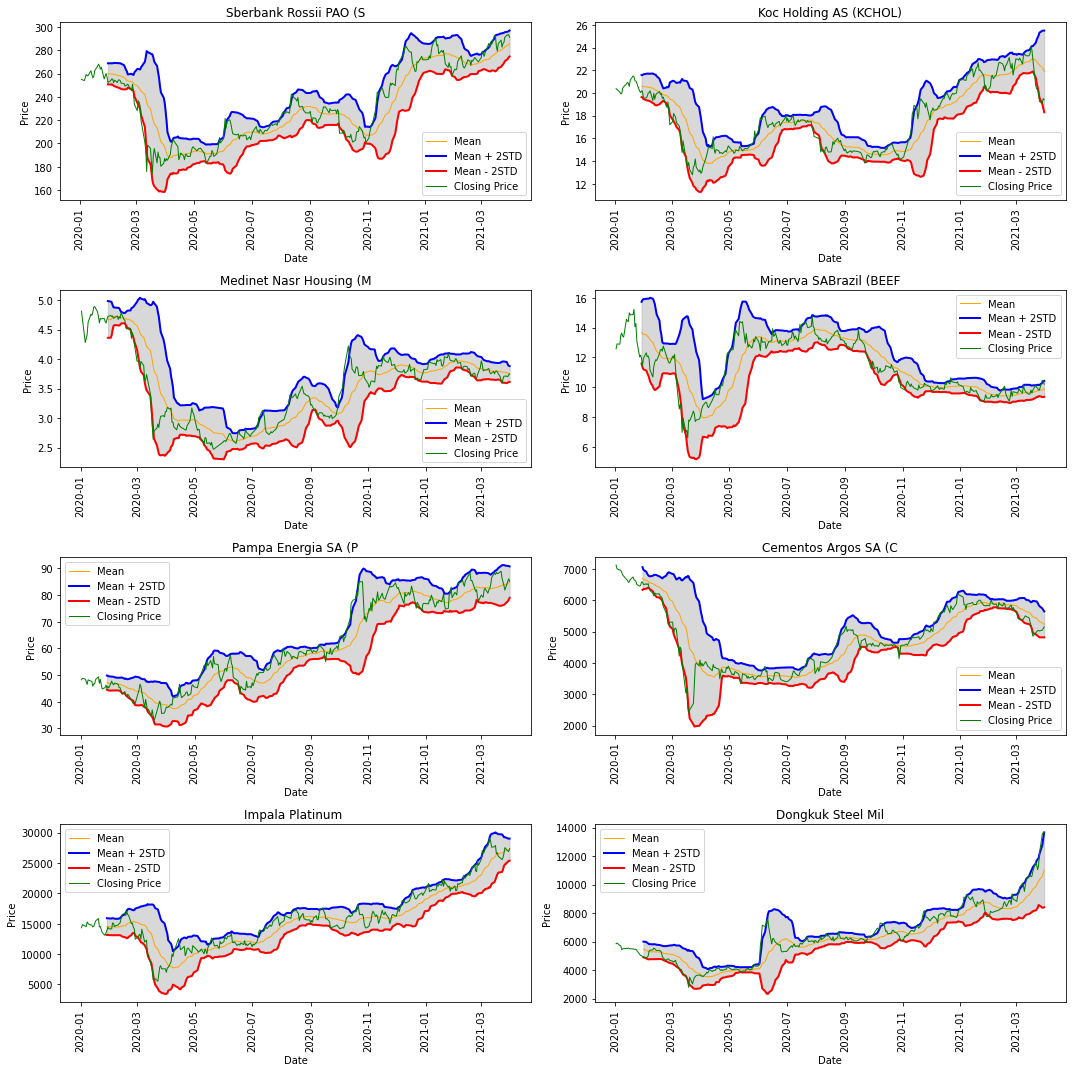

In [164]:
#plot closing price, traling mean, mean + sgima and mean - sigma for all the stocks in the Excel file
# call the functions read_clean_sheet (to create the dataframe for each Excel sheet) and plot_mean_sd (to plot the share prices
# with the Bollinger bands)

fig, axes = plt.subplots(4, 2, figsize = (15,15))

for ind in range(0,8):
    axes = plt.subplot(4,2,ind+1)
    df = read_clean_sheet ('trading_portfolio.xlsx', sheet_name = trading_portfolio.sheet_names[ind])
    plot_mean_sd (df, sigma = 2, sheet_name = trading_portfolio.sheet_names[ind]) # set sigma=2
plt.tight_layout()

# Concluding Remarks

In the previous runs of these models, the data from the Excel sheets read into the dataframe were used incorrectly. The 'Date' column was in the reverse order and and so were all the analyses. 
When the 'Date' column was sorted in ascending order, the profit making ability changed.

Ability of several Time Series models to inform trading decisions was examined in this notebook. Different models generated different profits for different stocks. The exception was Cementos Argos SA, where no model was able to generate a profit.

With an initial investment of 100,000 (in the currency the stock was traded in) and over the 3 month period, the maximum profit generated was as small as 1.3% (Medinet Nasr Housing) to as high as 66% (Dongkuk Steel Mil). The general range was about 12% - 66% during a three month period.

It must be noted however, that a general upward trend in share prices during the three month period (e.g. Pampa Energia SA, Impala Platinum and Dongkuk Steel Mil) resulted in higher profits than those that were more volatile (the exception to this being Minerva SABrazil (BEEF)

Surprisingly, of the 7 stocks where a profit was generated, the best Time Series model that generated the maximum profit was usually a Moving Average (errors) model.

In conclusion, in general, a simple Time Series model can be used to make informed trading decisions can result in sometimes very impressive profits. The higher the volatility of a stock, the lower the profits appear to be. 